# Modelo de redes neuronales cuánticas para clasificación binaria usando Qiskit de IBM

### integrantes: 
Sebastián Jara, Pablo Neira

## Abstract
En la actualidad, la computación cuántica ha adquirido una gran importancia debido a su potencial para resolver problemas complejos de manera más eficiente que la computación clásica. En este contexto, este trabajo propone un modelo de redes neuronales cuánticas (QNN) para realizar una clasificación binaria. La implementación computacional se realiza utilizando Qiskit, una biblioteca de código abierto desarrollada por IBM para la programación de sistemas de cómputo cuántico. El objetivo principal de este informe fue evaluar el desempeño de una QNN en un problema de clasificación binaria. Se realizaron experimentos para distinta cantidad de capas ocultas y se evalúa el accuracy alcanzado por la QNN utilizando el conjunto de datos Iris.

# Indice
## 1 Previos
### 1.1 Red Neuronal Cuántica
### 1.2 DataSet
## 2 Experimentos
### 2.1 ToolBox y Dataset
### 2.2 Arquitectura Propuesta
### 2.3 Entrenamiento
## 3 Resultados
## 4 Conclusiones

# 1 Previos

## 1.1 Red Neuronal Cuántica

La arquitectura general de una red neuronal cuántica (QNN, por sus siglas en inglés) se muestra en la figura 1 y se compone de tres partes. La primera parte corresponde al encoding o feature map que se usa para codificar en estados cuánticos el input de características $\vec{x}$ del conjunto de datos clásico. La segunda parte es el modelo variacional $W(\theta)$ utilizado para modificar los estados cuánticos del sistema, usando parámetros entrenables $\theta$. Finalmente, la última capa consiste en la medición de el estado final del sistema.

<img src="QNN1.png" width='800'>


<center>figura 1: Esquema de red neuronal cuántica (QNN)</center>


La Figura 2-(B) muestra que el modelo variacional $W(\theta)$ se puede repetir $n$ veces, lo que es análogo a las capas de una red neuronal clásica. Cuanto más grande sea el circuito cuántico, mejor se puede aproximar una función y, por lo tanto, mejor debería ser la generalización del algoritmo de aprendizaje automático. Al mismo tiempo, el hardware cuántico actual está limitado en tamaño y estabilidad. Los sistemas disponibles actuales no permiten la implementación de circuitos más profundos repitiendo los modelos variacionales. Por lo tanto, se debe minimizar la longitud de un circuito: el ruido que afecta al sistema cuántico durante los cálculos provoca inestabilidades y afecta las medidas resultantes, lo que puede puede llevar a resultados incorrectos.

<img src="QNN2.png" width='700'>

<center>figura 2: (A) Modelo variacional $W(\theta)$ con nueve par\'ametros entrenables. (B) El modelo variacional $W(\theta)$ puede ser repetido $n$ veces, esto puede ser considerado como capas de una QNN.</center>


## 1.2 Dataset

El conjunto de datos que se utiliza en los experimentos es el conjunto Iris
iris.html}. Este conjunto es ampliamente utilizado. El conjunto contiene información de 50 muestras de cada una de las tres especies de Iris: Iris setosa, Iris virgínica e Iris versicolor (ver figura 3-A). Para cada una de estas especies se midieron cuatro características de cada muestra: longitud y ancho de los sépalos y pétalos. Los sépalos son los que envuelven a las otras piezas florales en las primeras fases de desarrollo cuando la flor es solo un capullo. Por otro lado, los pétalos son la parte inferior del perianto y comprende las partes estériles de una flor. En la figura 3-B se distingue la diferencia entre pétalo y sépalo.

<img src="iris.png" width='700'>

<center>figura 3: (A) Las tres especies de Iris. (B) Pétalo y sépalo de una flor de Iris.</center>



# 2 Experimentos

Los experimentos ejecutados tienen como objetivo evaluar el desempeño de una QNN como clasificador binario, para distintas copias del modelo variacional $W(\theta)$ dentro de la arquitectura de la QNN.

## 2.1 ToolBox y carga del Dataset

In [29]:
from sklearn import model_selection, datasets
from qiskit import qiskit, QuantumCircuit, Aer, QuantumRegister, ClassicalRegister
import numpy as np

In [30]:
# Cargamos el dataset iris
iris = datasets.load_iris()

In [31]:
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,Y,test_size=0.33,random_state=42)

## 2.2 Arquitectura propuesta para el clasificador binario

<img src="arquitectura.png" width="500">

<center>figura 4: El circuito se compone de cuatro canales cuánticos y un canal clásico. A la izquierda del circuito se muestran las cuatro compuertdas de rotación $R_x$ asociadas al encoding. El input en este ejemplo es $\vec{x} = (5, 3.2, 1.2, 0.2)$. Entre las dos barreras verticales se describe el modelo variacional $W(\theta)$, con $\theta=(0.694, 0.208, 0.467, 0.121)$. Finalmente, en el lado derecho del circuito se define una compuerta de medición sobre el primer qubits.</center>




## Encoding: 
$$|\psi(\vec{x})\rangle := \mathcal{U}_{\Phi(\vec{x})}|0\rangle^4$$

## Modelo Variacional:

$$|\psi(\vec{x}, \theta)\rangle := W(\theta)\mathcal{U}_{\Phi(\vec{x})}|0\rangle^4$$


## Decoding:
$$Q(\vec{x},\theta) := \mathbb{P}_{|\psi(\vec{x}, \theta)\rangle, q_0}(|1\rangle)$$

### Código Computacional:

In [120]:
N=4 #número de características
n=1 #número de capas ocultas

# Esta función toma una entrada clasica y le aplica rotaciones a los N-Qubits
def feature_map(X):
    ''' Mapeo de atributos, toma una entrada clasica y 
    la codifica en los qubits usando rotaciones '''
    q = QuantumRegister(N) # Un qbit por feature
    c = ClassicalRegister(1) # tenemos solo una salida clasica
    qc = QuantumCircuit(q, c) # Instanciamos un circuito cuantico generico

    for i, x in enumerate(X):
        qc.rx(x, i) # rotación para cada atributo/qubit
    return qc, c 

# Circuito variacional, entrelaza los qubits y aplica rotaciones
def variational_circuit(qc, theta):
    for j in range(n):  #n es el numero de capas ocultas (o repeticiones del modelo variacional W(theta))
        for i in range(N-1):
            qc.cnot(i,i+1) #CNOTS para entrelazar
        qc.cnot(N-1, 0)
        for i in range(N):
            qc.ry(theta[i], i) #angulo de rotación theta para cada atributo
    return qc
#
def quantum_nn(X, theta, simulator=True):

    qc, c = feature_map(X) #codificamos clasico a cuantico
    qc = variational_circuit(qc, theta) # Aplicamos un circuito variacional
    qc.measure(0,c) # medimos

    shots = 10000 # Cantidad de veces repetimos esto, segun los papers 2 veces, segun la fuente 10mil
    backend = Aer.get_backend("qasm_simulator") # Este es un simulador, eventualmente podría usarse uno real
    job = qiskit.execute(qc, backend, shots=shots) # Ejecuta el simulador la cantidad de veces especificada
    result = job.result()
    counts = result.get_counts(qc) #cuenta las veces que colapso al estado básico cero y uno
    return counts["1"]/shots
    #return counts["1"]/shots, qc

### Ejemplo: 
Para caso de la figura anterior, $X[0]=(5,3.2,1.2,0.2)$ y $\theta = (0.694,0.208,0.467,0.121)$ se tiene:

In [121]:
quantum_nn((5,3.2,1.2,0.2) , (0.694,0.208,0.467,0.121))

0.6291

Sin embargo

In [122]:
Y[0]

0

## 2.3 Entrenamiento

## Función de Pérdida:
$$ \mathcal{L}(\theta; \vec{x}) = (Q(\vec{x}, \theta)  - y_{\vec{x}})^2$$

## Esquema de Optimización:

   $$ \theta_{j+1} = \theta_j - \eta \dfrac{\partial \mathcal{L}(\theta; \vec{x})}{\partial \theta}$$

## Cálculo del gradiente de la función de pérdida:

$$\dfrac{\partial \mathcal{L}(\theta; \vec{x})}{\partial \theta_i} = 2 (Q(\vec{x}, \theta)  - y_{\vec{x}}) \dfrac{\partial Q(\vec{x}, \theta)}{\partial \theta_i},$$
para i=1,2,3,4. Para la derivada usamos un esquema de diferencia finita: 

$$\dfrac{\partial Q(\vec{x}, \theta)}{\partial \theta_i} \approx \dfrac{Q(\vec{x}, \theta + \Delta \vec{e}_i) - Q(\vec{x}, \theta)}{\Delta}$$

## Desempeño: 
Para medir el desempeño del clasificador QNN se utiliza el accuracy (o exactitud), que representa la proporción de casos que el modelo ha acertado. Para lo anterior, si $Q(\vec{x}, \theta)$ es mayor a 0.5, clasifica el input de características $\vec{x}$ con la etiqueta 1, correspondiente a la clase setosa. En caso contrario, $Q(\vec{x}, \theta)$ menor a 0.5, se clasifica el input con la etiqueta 0, correspondiente a la clase veriscolor.  

### Código Computacional:

In [68]:
# Función de perdida cuadratica
def loss(prediction, target): 
      return (target - prediction)**2

import copy # Esto es realmente necesario? pues si, de lo contrario enlasa a los valores anteriores en vez de copiarlo

def gradient_loss(X, Y, theta):

        delta = 0.01

        grad = []

        for i in range(len(theta)):

            dtheta = copy.copy(theta)
            dtheta[i] += delta

            pred1 = quantum_nn(X, dtheta)
            pred2 = quantum_nn(X, theta)
            # finite difference
            grad.append( 2*(quantum_nn(X, theta) - Y)*(pred1 - pred2)/ delta  )

        return np.array(grad)
    
def accuracy(X, Y, theta):

        counter = 0
        for X_i, Y_i in zip(X, Y):

            prediction = quantum_nn(X_i, theta)

            if prediction < 0.5 and Y_i == 0:
                counter +=1
            elif prediction >= 0.5 and Y_i == 1:
                counter +=1
        return counter/len(Y)


## 2.3.1 Entrenamiento para una capa

In [37]:
eta = 0.05  # Step
n=1

loss_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.283 	 0.224
1 	 0.256 	 0.776
2 	 0.240 	 0.821
3 	 0.229 	 0.791
4 	 0.219 	 0.821
5 	 0.213 	 0.821
6 	 0.208 	 0.836
7 	 0.213 	 0.791
8 	 0.218 	 0.821
9 	 0.211 	 0.851
10 	 0.208 	 0.851
11 	 0.206 	 0.866
12 	 0.207 	 0.851
13 	 0.208 	 0.851
14 	 0.205 	 0.836


## Función de Pérdida

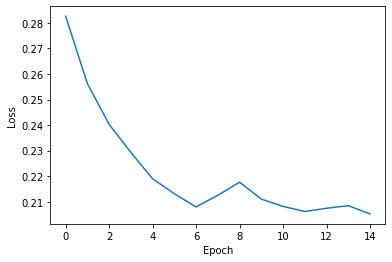

In [123]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [39]:
accuracy(X_test, Y_test, theta)

0.7272727272727273

In [46]:
theta

array([ 3.0454221, -0.3226248,  3.0507046, -0.3329658])

## 2.3.2 Entrenamiento para dos capas ocultas

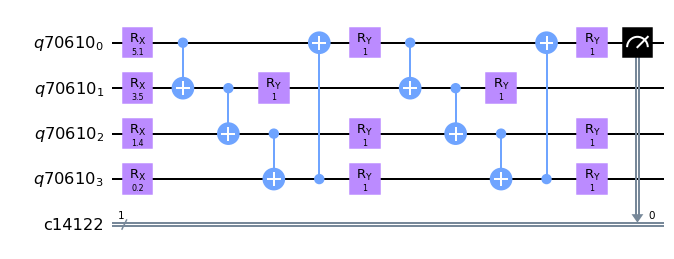

In [43]:
 quantum_nn(X[0], np.ones(N))[1].draw('mpl')

In [91]:
eta = 0.05  # Step
n=2

loss2_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss2_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss2_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.185 	 0.806
1 	 0.135 	 0.985
2 	 0.116 	 0.985
3 	 0.099 	 0.985
4 	 0.090 	 0.985
5 	 0.094 	 0.985
6 	 0.096 	 0.970
7 	 0.089 	 0.970
8 	 0.089 	 0.970
9 	 0.087 	 0.985
10 	 0.086 	 0.970
11 	 0.088 	 0.970
12 	 0.088 	 0.970
13 	 0.094 	 1.000
14 	 0.096 	 0.985


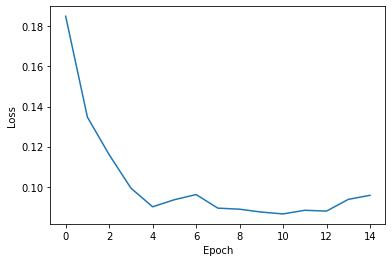

In [92]:
import matplotlib.pyplot as plt

plt.plot(loss2_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [93]:
accuracy(X_test, Y_test, theta)

1.0

In [94]:
theta

array([ 0.1383403, -0.6311806,  1.6364806, -0.0656813])

##  2.3.3 Entrenamiento para tres capas ocultas

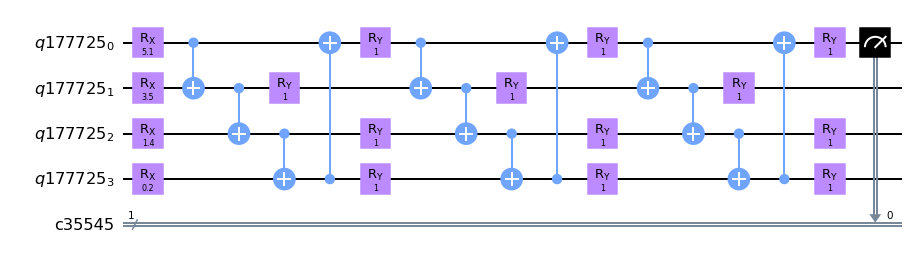

In [56]:
 quantum_nn(X[0], np.ones(N))[1].draw('mpl')

In [72]:
eta = 0.05  # Step
n=3

loss3_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss3_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss3_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.303 	 0.537
1 	 0.248 	 0.612
2 	 0.222 	 0.776
3 	 0.206 	 0.716
4 	 0.174 	 0.642
5 	 0.171 	 0.761
6 	 0.161 	 0.836
7 	 0.155 	 0.791
8 	 0.160 	 0.940
9 	 0.151 	 0.881
10 	 0.145 	 0.970
11 	 0.139 	 1.000
12 	 0.127 	 1.000
13 	 0.123 	 1.000
14 	 0.125 	 1.000


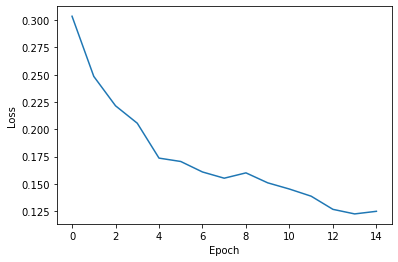

In [90]:
import matplotlib.pyplot as plt

plt.plot(loss3_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [74]:
accuracy(X_test, Y_test, theta)

1.0

In [75]:
theta

array([ 0.8863103,  3.8176174,  0.2680501, -1.1393356])

##  2.3.4 Entrenamiento para cuatro capas ocultas

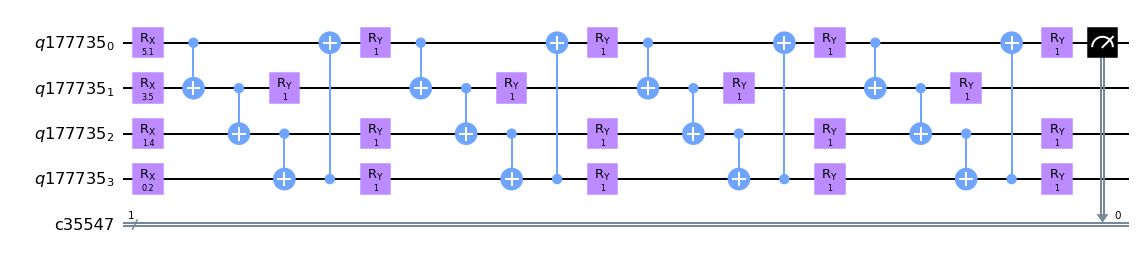

In [60]:
 quantum_nn(X[0], np.ones(N))[1].draw('mpl')

In [76]:
eta = 0.05  # Step
n=4

loss4_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss4_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss4_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.396 	 0.254
1 	 0.235 	 0.896
2 	 0.176 	 0.821
3 	 0.170 	 0.910
4 	 0.171 	 0.851
5 	 0.177 	 0.821
6 	 0.201 	 0.761
7 	 0.204 	 0.806
8 	 0.183 	 0.881
9 	 0.173 	 0.851
10 	 0.190 	 0.821
11 	 0.191 	 0.851
12 	 0.170 	 0.746
13 	 0.193 	 0.955
14 	 0.180 	 0.970


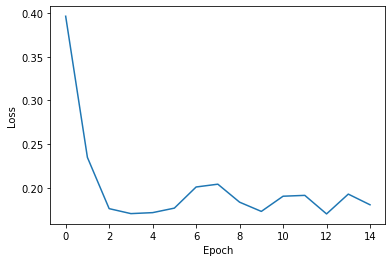

In [77]:
import matplotlib.pyplot as plt

plt.plot(loss4_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [78]:
accuracy(X_test, Y_test, theta)

0.9696969696969697

In [79]:
theta

array([-0.1410423,  0.7444717,  0.9079085,  0.8456841])

##  2.3.5 Entrenamiento para cinco capas ocultas

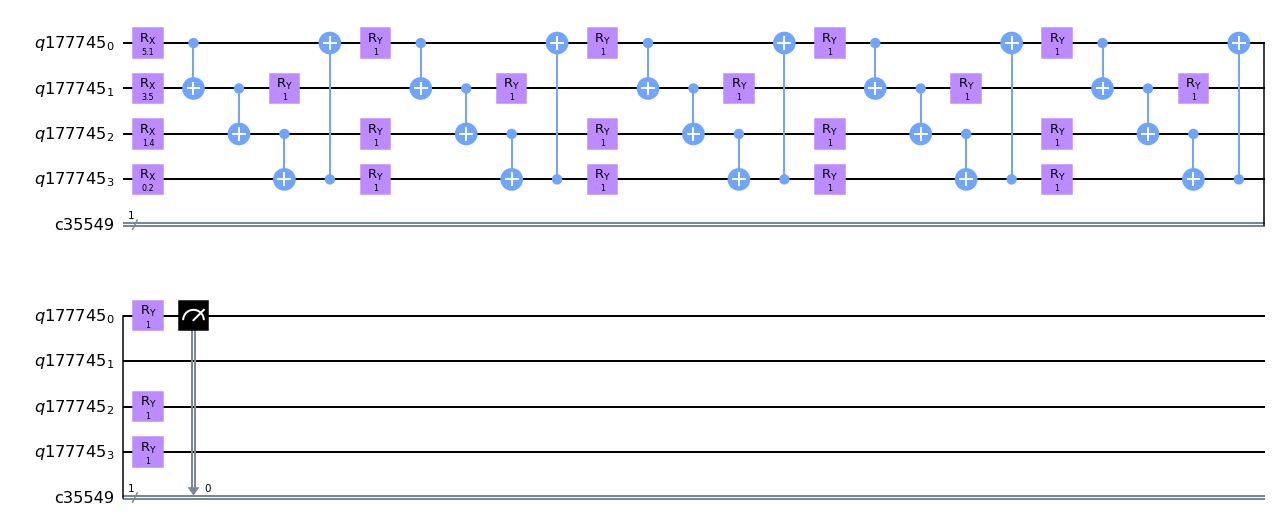

In [63]:
 quantum_nn(X[0], np.ones(N))[1].draw('mpl')

In [80]:
eta = 0.05  # Step
n=5

loss5_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss5_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss5_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.267 	 0.672
1 	 0.203 	 0.985
2 	 0.178 	 0.896
3 	 0.199 	 0.985
4 	 0.194 	 0.881
5 	 0.191 	 0.642
6 	 0.228 	 0.582
7 	 0.197 	 0.925
8 	 0.189 	 0.985
9 	 0.187 	 0.925
10 	 0.179 	 0.910
11 	 0.182 	 0.896
12 	 0.189 	 0.955
13 	 0.192 	 0.910
14 	 0.205 	 0.925


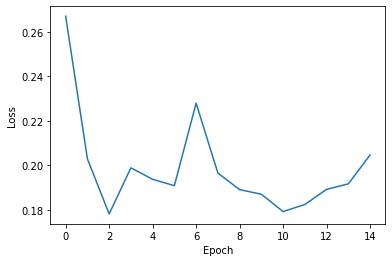

In [81]:
import matplotlib.pyplot as plt

plt.plot(loss5_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [82]:
accuracy(X_test, Y_test, theta)

0.9090909090909091

In [83]:
theta

array([1.414778 , 1.0009195, 0.1082275, 0.4948113])

##  2.3.6 Entrenamiento para seis capa oculta

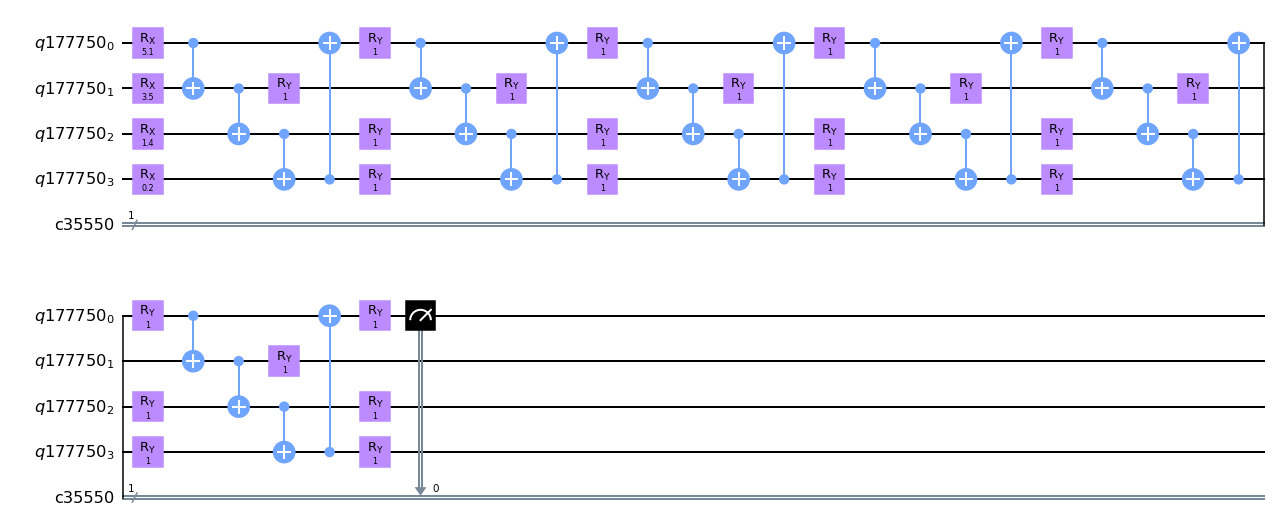

In [65]:
 quantum_nn(X[0], np.ones(N))[1].draw('mpl')

In [84]:
eta = 0.05  # Step
n=6

loss6_list = []
theta = np.ones(N) # Instanciamos un vector de angulos theta

print("Epoch \t Loss \t Tranining Accuracy")

# training epoch 
for i in range(15):

    loss_tmp = []

    for X_i, Y_i in zip(X_train, Y_train):

        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        # update theta,gradient descent rule
        theta = theta - eta * gradient_loss(X_i, Y_i, theta)
    
    loss6_list.append(np.mean(loss_tmp))
    acc = accuracy(X_train, Y_train, theta)
    print(f"{i} \t {loss6_list[-1]:.3f} \t {acc:.3f}")

Epoch 	 Loss 	 Tranining Accuracy
0 	 0.233 	 0.940
1 	 0.142 	 0.985
2 	 0.093 	 1.000
3 	 0.073 	 1.000
4 	 0.049 	 0.970
5 	 0.046 	 1.000
6 	 0.049 	 0.985
7 	 0.049 	 1.000
8 	 0.050 	 0.985
9 	 0.054 	 1.000
10 	 0.052 	 0.985
11 	 0.049 	 1.000
12 	 0.048 	 0.985
13 	 0.047 	 1.000
14 	 0.052 	 1.000


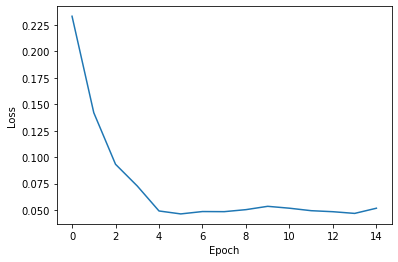

In [85]:
import matplotlib.pyplot as plt

plt.plot(loss6_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [86]:
accuracy(X_test, Y_test, theta)

1.0

In [87]:
theta

array([1.5240743, 0.9527223, 2.0438461, 2.1455844])

# 3 Resultados

## 3.1 Grafico de funciones de pérdida

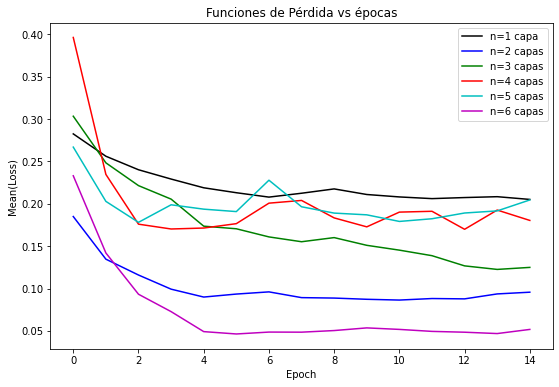

In [100]:
fig, ax = plt.subplots(figsize = (9,6))
plt.title('Funciones de Pérdida vs épocas')
ax.plot(range(len(loss_list)), loss_list, color = 'k', linestyle ='-', label = 'n=1 capa')
ax.plot(range(len(loss2_list)), loss2_list, color = 'b', linestyle ='-', label = 'n=2 capas')
ax.plot(range(len(loss3_list)), loss3_list, color = 'g', linestyle ='-', label = 'n=3 capas')
ax.plot(range(len(loss4_list)), loss4_list, color = 'r', linestyle ='-', label = 'n=4 capas')
ax.plot(range(len(loss5_list)), loss5_list, color = 'c', linestyle ='-', label = 'n=5 capas')
ax.plot(range(len(loss6_list)), loss6_list, color = 'm', linestyle ='-', label = 'n=6 capas')
handles, labels = ax.get_legend_handles_labels()
ax. legend(loc = 'upper right', )
plt.xlabel("Epoch")
plt.ylabel("Mean(Loss)")
plt.show
plt.savefig('Funciones de Pérdida', bbox_inches = 'tight')

## 3.2 Accuracy sobre el test data

<img src="acu.png" width='600'>



# 4 Conclusiones

En este trabajo se ha propuesto un modelo de redes neuronales cuánticas para realizar una clasificación binaria. Los experimentos realizados en  Qiskit de IBM consideraron diferentes números de capas ocultas, y evaluaron para cada caso el rendimiento de la QNN mediante la métrica de exactitud (accuracy), sobre el conjunto de datos de prueba. 

Los resultados obtenidos revelaron que la QNN implementada en Qiskit logra altos niveles de precisión en la clasificación binaria, a partir de dos capas ocultas. Además, se observó que considerar más de dos capas ocultas no juega un papel crucial en el rendimiento de la QNN. Lo anterior permite encontrar un modelo cuántico con alta capacidad de generalización en el conjunto de datos Iris.